In [27]:
import pandas as pd

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [28]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
                "hours-per-week", "native-country", "income"]

df = pd.read_csv(url, names=column_names)

In [29]:
# Show the first few rows of the dataset

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [30]:
# Replace '?' with NaN for easier handling of missing values
df.replace('?', float('nan'), inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)

# Label encode categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Separate features and target variable
X = df.drop('income', axis=1)
y = df['income']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26048, 14), (6513, 14), (26048,), (6513,))

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for training data
train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

# Define the Bayesian Neural Network
class BayesianNN(nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.layer1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=14, out_features=64)
        self.layer2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=32)
        self.layer3 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=32, out_features=1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))
        return x

# Initialize the model, loss, and optimizer
model = BayesianNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(5000):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        
        # Option 1: Reshape output
        output = output.squeeze()
        
        # Option 2: Reshape target (choose one option, not both)
        # target = target.view(-1, 1)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.32600072026252747
Epoch 2, Loss: 0.10940621793270111
Epoch 3, Loss: 0.34294456243515015
Epoch 4, Loss: 0.3308665156364441
Epoch 5, Loss: 0.19017967581748962
Epoch 6, Loss: 0.30140969157218933
Epoch 7, Loss: 0.3186119794845581
Epoch 8, Loss: 0.3690279424190521
Epoch 9, Loss: 0.3106846213340759
Epoch 10, Loss: 0.44470730423927307
Epoch 11, Loss: 0.28237128257751465
Epoch 12, Loss: 0.27928322553634644
Epoch 13, Loss: 0.30924856662750244
Epoch 14, Loss: 0.4148046374320984
Epoch 15, Loss: 0.30627015233039856
Epoch 16, Loss: 0.47651997208595276
Epoch 17, Loss: 0.3488488495349884
Epoch 18, Loss: 0.2099553793668747
Epoch 19, Loss: 0.37201815843582153
Epoch 20, Loss: 0.2185194492340088
Epoch 21, Loss: 0.21945734322071075
Epoch 22, Loss: 0.27121835947036743
Epoch 23, Loss: 0.25044646859169006
Epoch 24, Loss: 0.305257648229599
Epoch 25, Loss: 0.14983657002449036
Epoch 26, Loss: 0.3057785630226135
Epoch 27, Loss: 0.26644259691238403
Epoch 28, Loss: 0.2851184010505676
Epoch 29, Los

KeyboardInterrupt: 

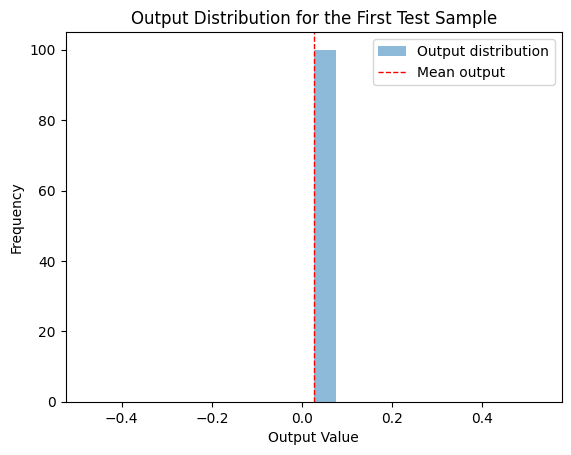

In [33]:
# Step 1: Run multiple forward passes to get a distribution over outputs
num_samples = 100
outputs = []

model.eval()
with torch.no_grad():
    for i in range(num_samples):
        output = model(X_test_tensor).squeeze().cpu().numpy()
        outputs.append(output)

# Step 2: Calculate the mean and standard deviation
outputs = np.array(outputs)
mean_outputs = outputs.mean(axis=0)
std_outputs = outputs.std(axis=0)

# Step 3: Visualization for a specific test sample (e.g., the first one)
import matplotlib.pyplot as plt
plt.hist(outputs[:, 0], bins=20, alpha=0.5, label='Output distribution')
plt.axvline(mean_outputs[0], color='r', linestyle='dashed', linewidth=1, label='Mean output')
plt.title('Output Distribution for the First Test Sample')
plt.xlabel('Output Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Step 4: Make decisions based on mean and std
threshold_std = 0.1
classification_results = []
for mean, std in zip(mean_outputs, std_outputs):
    if std < threshold_std:
        classification_results.append((int(mean > 0.5), 'Certain'))
    else:
        classification_results.append((int(mean > 0.5), 'Uncertain'))

# The classification_results list will contain tuples (class, certainty) for each test sample

In [34]:
classification_results

[(0, 'Certain'),
 (0, 'Certain'),
 (1, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (1, 'Certain'),
 (1, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (1, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (1, 'Certain'),
 (1, 'Certain'),
 (1, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (1, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (1, 'Certain'),
 (0, 'Certain'),
 (1, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'),
 (0, 'Certain'

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



# Step 5: Evaluate the model
# Convert mean outputs to binary classification labels
predicted_labels = (mean_outputs > 0.5).astype(int)

# True labels
true_labels = y_test_tensor.cpu().numpy()

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix: \n{conf_matrix}")


Accuracy: 0.8530631045601106
Precision: 0.7520525451559934
Recall: 0.5830681094844048
F1 Score: 0.6568662603083542
Confusion Matrix: 
[[4640  302]
 [ 655  916]]


In [36]:
# Normal neural network in comparison:

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for training data
train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

# Define a standard (non-Bayesian) Neural Network
class StandardNN(nn.Module):
    def __init__(self):
        super(StandardNN, self).__init__()
        self.layer1 = nn.Linear(14, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))
        return x

# Initialize the model, loss, and optimizer
model = StandardNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(500):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
# Evaluate the model
model.eval()
with torch.no_grad():
    test_output = model(X_test_tensor).squeeze().cpu().numpy()
    predicted_labels = (test_output > 0.5).astype(int)
    true_labels = y_test_tensor.cpu().numpy()

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

accuracy, precision, recall, f1, conf_matrix

(0.8274220789190849,
 0.673121611154144,
 0.5531508593252705,
 0.6072676450034941,
 array([[4520,  422],
        [ 702,  869]], dtype=int64))

In [39]:
# Normal vs Bayesian performance on the same df

C:\Programmieren\Leaguify_Website\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Programmieren\Leaguify_Website\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Programmieren\Leaguify_Website\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Programmieren\Leaguify_Website\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

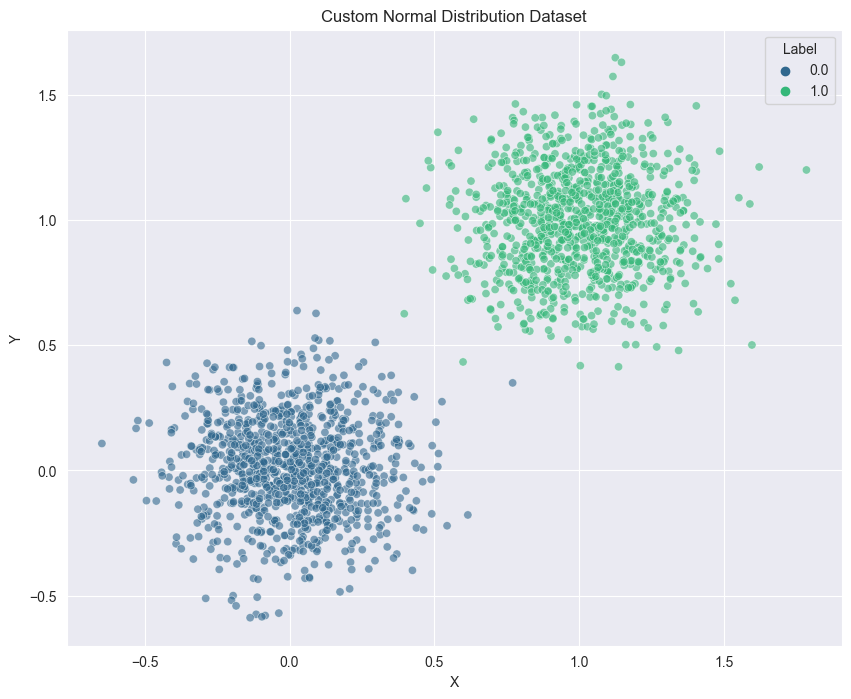

,X,Y,Label
0,0.099343,0.279871,0.0
1,-0.027653,0.184927,0.0
2,0.129538,0.011926,0.0
3,0.304606,-0.129387,0.0
4,-0.046831,0.139645,0.0


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Generate custom normal distribution dataset
n_points = 1000
mean_1, std_1 = 0, 0.2
mean_2, std_2 = 1, 0.2

# Generate points for two categories
x1 = np.random.normal(mean_1, std_1, n_points)
y1 = np.random.normal(mean_1, std_1, n_points)
label_1 = np.zeros(n_points)

x2 = np.random.normal(mean_2, std_2, n_points)
y2 = np.random.normal(mean_2, std_2, n_points)
label_2 = np.ones(n_points)

# Combine the points and labels
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])
labels = np.concatenate([label_1, label_2])

# Create a DataFrame to hold the dataset
dataset = pd.DataFrame({
    'X': x,
    'Y': y,
    'Label': labels
})

# Visualize the generated dataset
plt.figure(figsize=(10, 8))
sns.scatterplot(data=dataset, x='X', y='Y', hue='Label', palette='viridis', alpha=0.6)
plt.title('Custom Normal Distribution Dataset')
plt.show()

dataset.head()

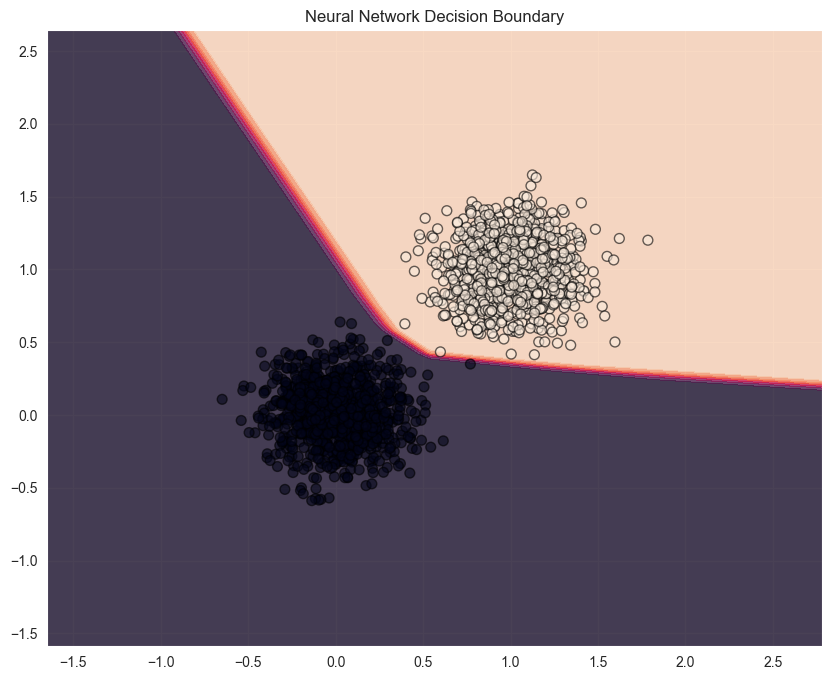

In [2]:
# Importing PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

# Prepare the dataset for PyTorch
X = dataset[['X', 'Y']].values
y = dataset['Label'].values

X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

# Create DataLoader
from torch.utils.data import DataLoader, TensorDataset

dataset_tensor = TensorDataset(X_tensor, y_tensor)
data_loader = DataLoader(dataset_tensor, batch_size=32, shuffle=True)

# Define Neural Network Architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(2, 16)
        self.layer2 = nn.Linear(16, 8)
        self.layer3 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))
        return x

# Initialize Neural Network and Optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

# Training the Neural Network
n_epochs = 100
for epoch in range(n_epochs):
    for batch_X, batch_y in data_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

# Visualize the neural network decision boundary
def plot_decision_boundary(model, X, y):
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.detach().numpy()
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50, linewidth=1, alpha=0.6)
    plt.title('Neural Network Decision Boundary')
    plt.show()

plot_decision_boundary(model, X, y)

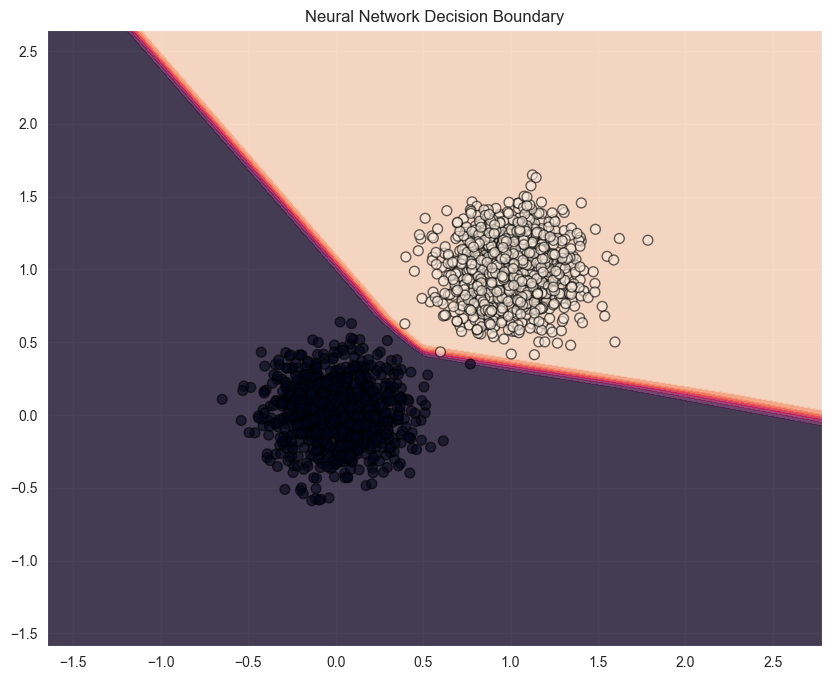

In [3]:
# Importing PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

# Define Bayesian Neural Network Architecture
class BayesianNeuralNetwork(nn.Module):
    def __init__(self):
        super(BayesianNeuralNetwork, self).__init__()
        self.layer1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2, out_features=16)
        self.layer2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=8)
        self.layer3 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=8, out_features=1)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))
        return x

# Initialize Bayesian Neural Network and Optimizer
bayesian_model = BayesianNeuralNetwork()
optimizer = optim.Adam(bayesian_model.parameters(), lr=0.01)

# Use Binary Cross-Entropy loss
criterion = nn.BCELoss()

# Training the Bayesian Neural Network
n_epochs = 100
for epoch in range(n_epochs):
    for batch_X, batch_y in data_loader:
        optimizer.zero_grad()
        output = bayesian_model(batch_X)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

# Visualize the Bayesian Neural Network decision boundary
plot_decision_boundary(bayesian_model, X, y)

In [5]:
def plot_bayesian_decision_boundary(model, X, y, n_forward_passes=10):
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z_list = []
    for i in range(n_forward_passes):
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z.detach().numpy()
        Z_list.append(Z.reshape(xx.shape))

    Z_mean = np.mean(Z_list, axis=0)
    Z_std = np.std(Z_list, axis=0)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z_mean, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50, linewidth=1, alpha=0.6)
    plt.title('Bayesian Neural Network Decision Boundary with Uncertainty')
    
    # Add Uncertainty Contours
    plt.contour(xx, yy, Z_std, levels=[0.1, 0.2, 0.3], colors='r', linewidths=1)
    
    plt.show()

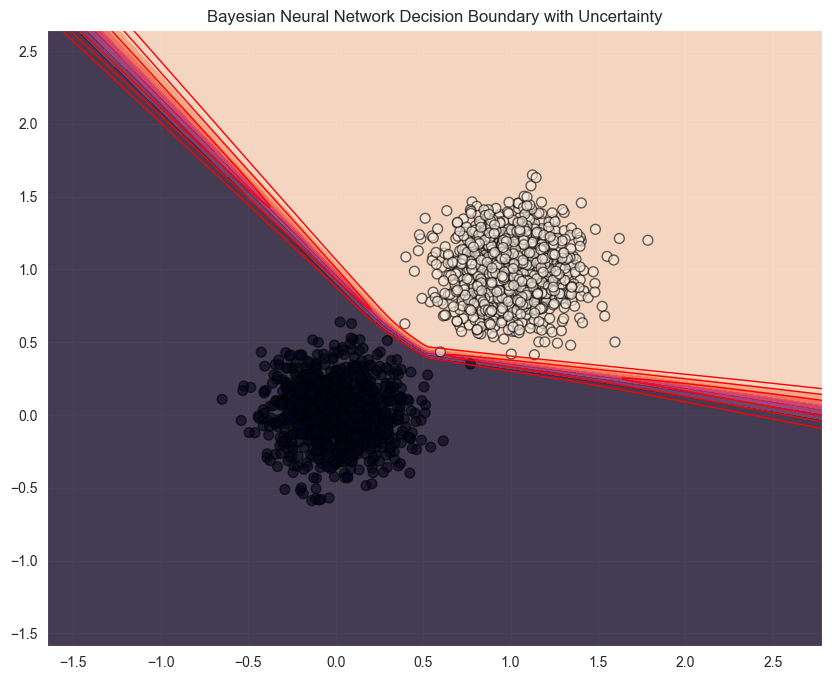

In [8]:
# After training your Bayesian Neural Network model
plot_bayesian_decision_boundary(bayesian_model, X, y, n_forward_passes=100)